# loading data

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

# plotting and visualization

import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import sklearn.model_selection
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score,cross_validate
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score,precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

import pickle

from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

import os

In [2]:
X_train = pd.read_csv("../Capstone_Two_Project/data/processed/X_train.csv", index_col = 0)
X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,free_SO2_ratio,alcohol_surgar_ratio,sugar_acidity_ratio,fixed_acidity_ratio
0,0.247934,0.120000,0.192771,0.098160,0.053156,0.128472,0.258065,0.130904,0.410853,0.168539,0.405797,0.358702,0.078052,0.124245,0.839710
1,0.239669,0.113333,0.445783,0.288344,0.074751,0.149306,0.375576,0.256217,0.612403,0.129213,0.260870,0.284783,0.018717,0.366162,0.845020
2,0.190083,0.213333,0.096386,0.018405,0.099668,0.034722,0.043779,0.161751,0.542636,0.292135,0.304348,0.500078,0.310672,0.028200,0.686411
3,0.231405,0.126667,0.150602,0.038344,0.071429,0.138889,0.419355,0.084635,0.403101,0.101124,0.478261,0.234125,0.198261,0.051629,0.824361
4,0.165289,0.086667,0.192771,0.015337,0.059801,0.128472,0.205069,0.045306,0.395349,0.404494,0.637681,0.452140,0.432972,0.026762,0.851406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6031,0.232797,0.065614,0.227901,0.014062,0.037087,0.091411,0.240359,0.082382,0.416075,0.189178,0.497635,0.269405,0.421025,0.020978,0.905414
6032,0.292554,0.133367,0.201169,0.090634,0.024262,0.054529,0.219156,0.127660,0.200748,0.176455,0.373884,0.167985,0.083460,0.105738,0.839941
6033,0.300610,0.162201,0.197012,0.086024,0.037714,0.043268,0.278422,0.099410,0.337849,0.107232,0.603911,0.099637,0.102145,0.098697,0.810163
6034,0.213175,0.207843,0.125620,0.037667,0.040551,0.086602,0.247697,0.056601,0.368446,0.171679,0.684143,0.248503,0.230315,0.051596,0.709345


In [3]:
X_test = pd.read_csv("../Capstone_Two_Project/data/processed/X_test.csv", index_col = 0)

In [4]:
y_train = pd.read_csv("../Capstone_Two_Project/data/processed/y_train.csv",index_col = False)

y_train=y_train.drop('Unnamed: 0',axis=1)

In [5]:
y_test = pd.read_csv("../Capstone_Two_Project/data/processed/y_test.csv", index_col = False)
y_test=y_test.drop('Unnamed: 0',axis=1)

# Modeling

## Metrics for model performance

For a classification machine learning, several metrics such as accuracy, recall, F1 and ROC_AUC are used in model performance evaluation. The project purpose is to predict good quality wine, and the dataset is imblanced, therefore the model with highest precision values with relative high accuracy among the three models:Logisticregression, randomforest, XGBoost will be the winner. 

## Baseline model

dummyclassifier is used in modeling prediction. it will serve as the baseline modeling, good models should shows better metris than it.

In [59]:
dummy = DummyClassifier(strategy ="stratified",random_state = 123)
dummy.fit(X_train.values,y_train.values.ravel())
y_pred = dummy.predict(X_test.values)
y_pred_probs = dummy.predict_proba(X_test.values) [:,1]
roc_auc_score_dummy = roc_auc_score(y_test, y_pred_probs)
print(roc_auc_score_dummy)


0.47562273628754986


dummy: precision=0.677
report:               precision    recall  f1-score   support

           0       0.79      0.48      0.60      1293
           1       0.18      0.47      0.25       303

    accuracy                           0.48      1596
   macro avg       0.48      0.48      0.43      1596
weighted avg       0.68      0.48      0.53      1596
 



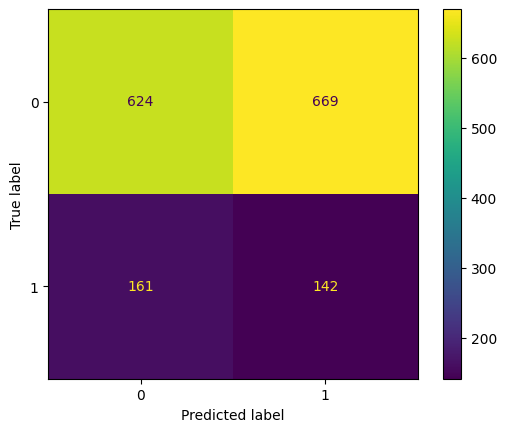

In [7]:
pc_dummy = precision_score(y_test, y_pred,average='weighted')
precision_score_list.append(pc_dummy)
report_dummy = classification_report(y_test, y_pred)
cm_dummy = confusion_matrix(y_test, y_pred)
print('dummy: precision=%.3f' % (pc_dummy))
print("report:", report_dummy,"\n")
ConfusionMatrixDisplay(confusion_matrix=cm_dummy,display_labels=dummy.classes_).plot()
plt.show()

In dummy model, the precison for predict good win is 0.20. overall precision is 0.697.

three models:logisticregression, random forest and XGBoost Model will be selected. Through compare the cross validtion scores, the final model will be select and final tuned. Also, the number of features used in modeling was controlled bu selectkbest algorithms. 

## Logisticregression model

### make a pipeline

In [8]:
from sklearn.pipeline import Pipeline
pipe_log = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression, k =5)),("model",
    LogisticRegression())]
)

In [9]:
pipe_log.fit(X_train.values, y_train.values.ravel())

Pipeline(steps=[('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x0000027DFBE74430>)),
                ('model', LogisticRegression())])

In [10]:
y_tr_pred_log = pipe_log.predict(X_train.values)
y_te_pred_log= pipe_log.predict(X_test.values)
y_pred_log_probs = pipe_log.predict_proba(X_test.values) [:,1]
print(roc_auc_score(y_test, y_pred_log_probs))
precision_score(y_train, y_tr_pred_log, average = "weighted" ), precision_score(y_test, y_te_pred_log, average ="weighted")

0.8100497984833287


(0.7599341499138335, 0.8246233273241583)

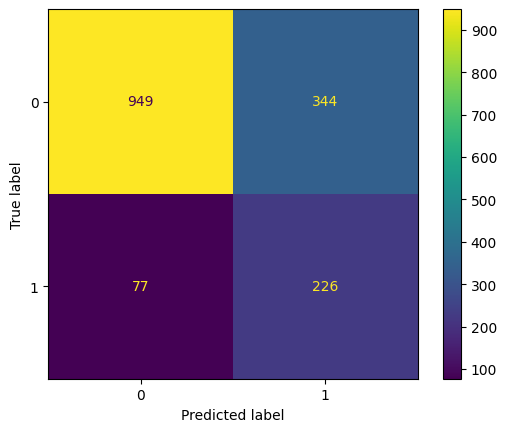

              precision    recall  f1-score   support

           0       0.92      0.73      0.82      1293
           1       0.40      0.75      0.52       303

    accuracy                           0.74      1596
   macro avg       0.66      0.74      0.67      1596
weighted avg       0.82      0.74      0.76      1596



In [11]:
report_log = classification_report(y_test, y_te_pred_log)
cm_log = confusion_matrix(y_test, y_te_pred_log)
ConfusionMatrixDisplay(confusion_matrix=cm_log,display_labels=pipe_log.classes_).plot()
plt.show()
print(classification_report(y_test, y_te_pred_log))

### Assessing performance using cross-validation

In [12]:
cv_results_log = cross_validate(pipe_log, X_train, y_train.values.ravel(), cv=5,scoring = "precision")

In [13]:
cv_scores_log = cv_results_log['test_score']
cv_scores_log

array([0.75653595, 0.7484472 , 0.72554745, 0.74223602, 0.73611111])

In [14]:
cv_scores_mean_log = np.mean(cv_scores_log)
cv_score_std_log = np.std(cv_scores_log)

### tunning logisticregression model

In [15]:
#k = [k+1 for k in range(len(X_train.columns))]
c_values = [0.01,0.1,1.0,10,100]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
grid_params = {'model__C':c_values,'model__solver':solvers}
#grid_params = {'feature_selection__k': k, 'model__C':c_values,'model__solver':solvers}
#grid_params = {'feature_slection__k': k}

In [16]:
log_grid_cv = GridSearchCV(pipe_log, param_grid=grid_params,scoring="precision", cv=5, n_jobs=-1)
log_grid_cv.fit(X_train, y_train.values.ravel())
score_mean = log_grid_cv.cv_results_['mean_test_score']
score_std = log_grid_cv.cv_results_['std_test_score']
log_grid_cv.best_params_

{'model__C': 0.01, 'model__solver': 'lbfgs'}

In [17]:
selected = log_grid_cv.best_estimator_.named_steps.feature_selection.get_support()
coefs = log_grid_cv.best_estimator_.named_steps.model.coef_
features = X_train.columns[selected]
pd.Series(coefs.ravel(), index = features.ravel()).sort_values(ascending=False)

alcohol                1.852891
fixed_acidity_ratio    0.495268
chlorides             -0.279247
density               -0.428324
volatile_acidity      -0.490893
dtype: float64

In [18]:
cv_log = cross_validate(log_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='precision', cv=5, n_jobs=-1)
cv_scores_log = cv_log['test_score']
np.mean(cv_scores_log), np.std(cv_scores_log)

y_tr_pred = log_grid_cv.best_estimator_.predict(X_train)
y_te_pred = log_grid_cv.best_estimator_.predict(X_test)
y_pred_probs = log_grid_cv.best_estimator_.predict_proba(X_test.values) [:,1]
print(roc_auc_score(y_test, y_pred_probs))

0.8083166785356027


C:\Users\Yan Zhang\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


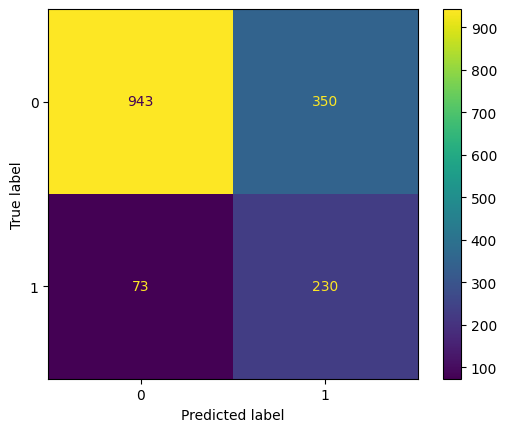

              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1293
           1       0.40      0.76      0.52       303

    accuracy                           0.73      1596
   macro avg       0.66      0.74      0.67      1596
weighted avg       0.83      0.73      0.76      1596



In [19]:
report_log = classification_report(y_test, y_te_pred)
cm_log = confusion_matrix(y_test, y_te_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_log,
                       display_labels=log_grid_cv.classes_).plot()
plt.show()
print(classification_report(y_test, y_te_pred))

## Random forest 

### using the default setting

In [20]:
pipe_rf = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression,k=5)),("rf",
    RandomForestClassifier(random_state= 123))]
)

In [21]:
pipe_rf.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x0000027DFBE74430>)),
                ('rf', RandomForestClassifier(random_state=123))])

In [22]:
y_tr_pred_rf = pipe_rf.predict(X_train)
y_te_pred_rf = pipe_rf.predict(X_test)

In [23]:
y_pred_rf_probs = pipe_rf.predict_proba(X_test.values) [:,1]
print(roc_auc_score(y_test, y_pred_rf_probs))

0.8045415910500564


C:\Users\Yan Zhang\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


In [24]:
precision_score(y_train, y_tr_pred_rf, average = "weighted" ), precision_score(y_test, y_te_pred_rf, average ="weighted")

(1.0, 0.8052149337759484)

### check cross validation score

In [25]:
cv_results_rf = cross_validate(pipe_rf, X_train, y_train.values.ravel(), cv=5,scoring = "precision")
cv_scores_rf = cv_results_rf['test_score']

In [26]:
precision_score(y_train, y_tr_pred_rf), precision_score(y_test, y_te_pred_rf)

(1.0, 0.45429362880886426)

In [27]:
np.mean(cv_scores_rf), np.std(cv_scores_rf)

(0.8394490308826524, 0.018390079282393803)

### tunning random forest model

In [28]:
pipe = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression,k=5)),("rf",
    RandomForestClassifier(random_state= 123))]
)

#k = [k+1 for k in range(len(X_train.columns))]
n_est = [50,100,300,500]
grid_params = {'rf__n_estimators': n_est}

# grid_params = {'feature_selection__k': k,
#         'rf__n_estimators': n_est
# }

rf_grid_cv = GridSearchCV(pipe, param_grid=grid_params,scoring ="precision", cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train.values.ravel())
rf_grid_cv.best_params_

{'rf__n_estimators': 500}

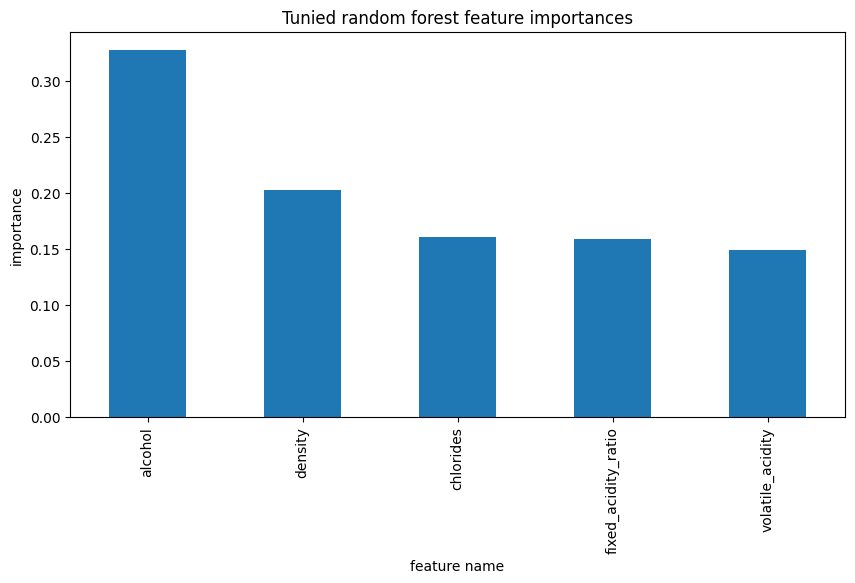

In [29]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 

features_imp = rf_grid_cv.best_estimator_.named_steps.rf.feature_importances_

feature_names =  rf_grid_cv.best_estimator_.named_steps.feature_selection.get_feature_names_out()

plt.subplots(figsize=(10, 5))
rf_feat = pd.Series(features_imp, index=feature_names).sort_values(ascending=False)
rf_feat.plot(kind='bar')
plt.xlabel('feature name')
plt.ylabel('importance')
plt.title('Tunied random forest feature importances');

In [30]:
cv_rf = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='precision', cv=5, n_jobs=-1)
cv_scores_rf = cv_rf['test_score']
np.mean(cv_scores_rf), np.std(cv_scores_rf)

y_tr_pred = rf_grid_cv.best_estimator_.predict(X_train)
y_te_pred = rf_grid_cv.best_estimator_.predict(X_test)
y_pred_probs = rf_grid_cv.best_estimator_.predict_proba(X_test.values) [:,1]
print(roc_auc_score(y_test, y_pred_probs))

0.8057067887763255


C:\Users\Yan Zhang\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


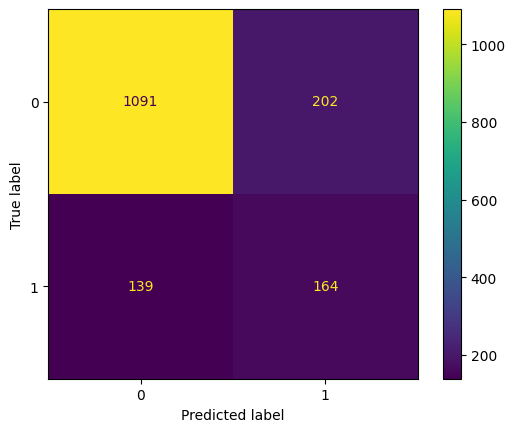

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1293
           1       0.45      0.54      0.49       303

    accuracy                           0.79      1596
   macro avg       0.67      0.69      0.68      1596
weighted avg       0.80      0.79      0.79      1596



In [31]:
report_rf = classification_report(y_test, y_te_pred)
cm_rf = confusion_matrix(y_test, y_te_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                       display_labels=rf_grid_cv.classes_).plot()
plt.show()
print(classification_report(y_test, y_te_pred))

## XGBoost model

### Initial modeling

In [32]:
pipe_xgb = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression,k=5)),("xgb",
    XGBClassifier(objective='binary:logistic',learning_rate=0.1 , n_estimators=300, random_state=123))]
)

In [33]:
pipe_xgb.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x0000027DFBE74430>)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=Non...row_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, random_state=123, ...))])

In [34]:
y_tr_pred_xgb = pipe_xgb.predict(X_train)
y_te_pred_xgb = pipe_xgb.predict(X_test)
y_pred_xgb_probs = pipe_xgb.predict_proba(X_test.values) [:,1]
print(roc_auc_score(y_test, y_pred_xgb_probs))

0.7844128960459852


C:\Users\Yan Zhang\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


In [35]:
precision_score(y_train, y_tr_pred_xgb, average = "weighted" ), precision_score(y_test, y_te_pred_xgb, average ="weighted")

(0.9706945998792486, 0.7940586736756308)

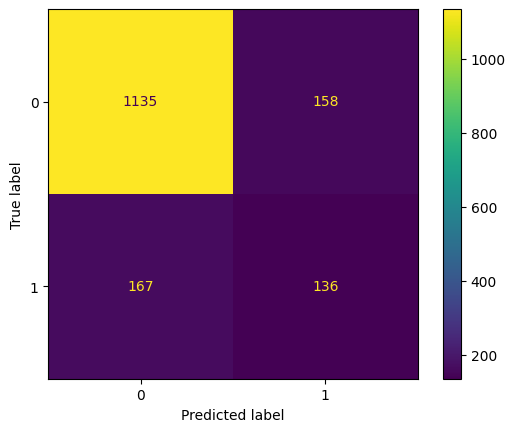

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1293
           1       0.46      0.45      0.46       303

    accuracy                           0.80      1596
   macro avg       0.67      0.66      0.67      1596
weighted avg       0.79      0.80      0.80      1596



In [36]:
report_log = classification_report(y_test, y_te_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_te_pred_xgb)
ConfusionMatrixDisplay(confusion_matrix=cm_xgb,display_labels=pipe_xgb.classes_).plot()
plt.show()
print(classification_report(y_test, y_te_pred_xgb))

### cross validation

In [37]:
cv_results_xgb = cross_validate(pipe_xgb, X_train, y_train.values.ravel(), cv=5,scoring = "precision")
cv_scores_xgb = cv_results_xgb['test_score']
cv_scores_xgb

array([0.87368421, 0.8576    , 0.84615385, 0.84763314, 0.87003058])

In [38]:
np.mean(cv_scores_xgb), np.std(cv_scores_xgb)

(0.8590203547629185, 0.01125599350528554)

### xgb model tunning

In [39]:
pipe_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feature_selection', 'xgb', 'feature_selection__k', 'feature_selection__score_func', 'xgb__objective', 'xgb__base_score', 'xgb__booster', 'xgb__callbacks', 'xgb__colsample_bylevel', 'xgb__colsample_bynode', 'xgb__colsample_bytree', 'xgb__device', 'xgb__early_stopping_rounds', 'xgb__enable_categorical', 'xgb__eval_metric', 'xgb__feature_types', 'xgb__gamma', 'xgb__grow_policy', 'xgb__importance_type', 'xgb__interaction_constraints', 'xgb__learning_rate', 'xgb__max_bin', 'xgb__max_cat_threshold', 'xgb__max_cat_to_onehot', 'xgb__max_delta_step', 'xgb__max_depth', 'xgb__max_leaves', 'xgb__min_child_weight', 'xgb__missing', 'xgb__monotone_constraints', 'xgb__multi_strategy', 'xgb__n_estimators', 'xgb__n_jobs', 'xgb__num_parallel_tree', 'xgb__random_state', 'xgb__reg_alpha', 'xgb__reg_lambda', 'xgb__sampling_method', 'xgb__scale_pos_weight', 'xgb__subsample', 'xgb__tree_method', 'xgb__validate_parameters', 'xgb__verbosity'])

In [40]:
gbm_param_grid = {
   'xgb__learning_rate' : np.arange(0.05, 1,0.05),
    'xgb__max_depth': np.arange(3, 10, 1),
    'xgb__n_estimators': np.arange(50,200, 50)
}


In [41]:
from sklearn.model_selection import RandomizedSearchCV
xgb_randomized_cv = RandomizedSearchCV(pipe_xgb,gbm_param_grid,n_iter=2,scoring='precision',cv=5,verbose=1)
xgb_randomized_cv.fit(X_train, y_train.values.ravel())


Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('feature_selection',
                                              SelectKBest(k=5,
                                                          score_func=<function f_regression at 0x0000027DFBE74430>)),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric...
                                                            multi_strategy=None,
                                                            n_estimators=300,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=123, ...))]),
                   n_iter=2,
                   param_distributions={'xgb__learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'xgb__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'xgb__n_estimators': array([ 50, 100, 150])},
                   scoring='precision', verbose=1)

In [42]:
xgb_randomized_cv.best_params_

{'xgb__n_estimators': 100,
 'xgb__max_depth': 8,
 'xgb__learning_rate': 0.7000000000000001}

In [43]:
xgb_features_imp =xgb_randomized_cv.best_estimator_.named_steps["xgb"].feature_importances_
feature_names = xgb_randomized_cv.best_estimator_.named_steps.feature_selection.get_feature_names_out()

<Axes: title={'center': 'xgb model feature importance'}, xlabel='feature important ratio', ylabel='Feature'>

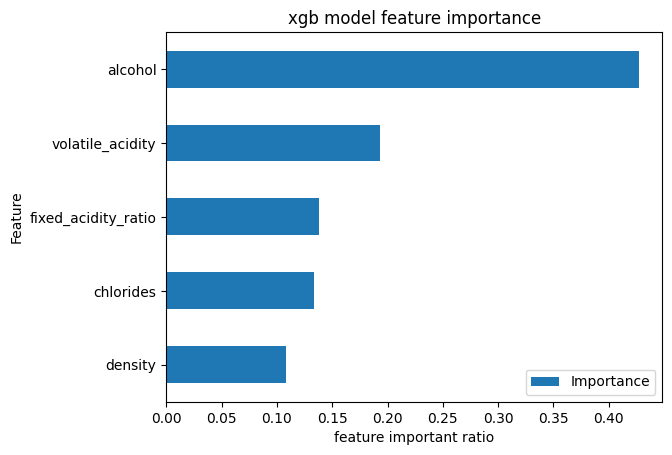

In [44]:

# making a pandas dataframe
data = list(zip(feature_names, xgb_features_imp))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance')
df_importances.plot.barh(x='Feature', y='Importance',xlabel = "feature important ratio", title="xgb model feature importance")

In [45]:
cv_xgb= cross_validate(xgb_randomized_cv.best_estimator_, X_train, y_train, 
                            scoring='precision', cv=5, n_jobs=-1)

cv_scores_xgb = cv_xgb['test_score']
np.mean(cv_scores_xgb), np.std(cv_scores_xgb)

(0.854969719643865, 0.02011777768283537)

In [46]:
y_tr_pred = xgb_randomized_cv.best_estimator_.predict(X_train)
y_te_pred = xgb_randomized_cv.best_estimator_.predict(X_test)
y_pred_probs = xgb_randomized_cv.best_estimator_.predict_proba(X_test.values) [:,1]
print(roc_auc_score(y_test, y_pred_probs))

0.7718496907695411


C:\Users\Yan Zhang\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


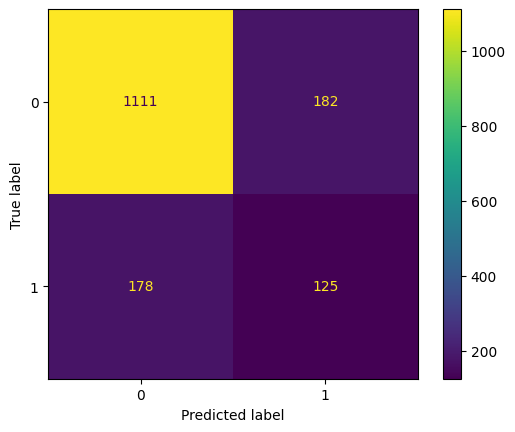

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1293
           1       0.41      0.41      0.41       303

    accuracy                           0.77      1596
   macro avg       0.63      0.64      0.64      1596
weighted avg       0.78      0.77      0.78      1596



In [47]:
report_xgb = classification_report(y_test, y_te_pred)
cm_xgb = confusion_matrix(y_test, y_te_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_xgb,display_labels=xgb_randomized_cv.classes_).plot()
plt.show()
print(classification_report(y_test, y_te_pred))

## evaluate the three model performance

In [48]:
cv_dict = {
    "cv_scores_log": np.mean(cv_scores_log),
    "cv_scores_rf": np.mean(cv_scores_rf),
    "cv_scores_xgb": np.mean(cv_scores_xgb)
}
cv_score_model = pd.DataFrame(cv_dict.items(), columns=["model","cv_score"])
cv_score_model

,model,cv_score
0,cv_scores_log,0.745646
1,cv_scores_rf,0.839557
2,cv_scores_xgb,0.854970


## Save best model object frome pipeline

In [49]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()


In [50]:
import pickle

In [51]:
# save the model to disk
filename = 'wine_quality_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

## Modeling the wine quality

In [52]:
df= pd.read_csv("../Capstone_Two_Project/data/processed/df_model.csv", index_col = "wine_type_white")
df = df.drop("Unnamed: 0",axis =1)
df


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,free_SO2_ratio,alcohol_surgar_ratio,sugar_acidity_ratio,fixed_acidity_ratio
wine_type_white,,,,,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,32.352941,494.736842,23.456790,91.358025
0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,37.313433,376.923077,29.953917,89.861751
0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,27.777778,426.086957,26.869159,91.121495
0,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0,28.333333,515.789474,16.550523,97.560976
0,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,0,32.500000,522.222222,22.332506,91.811414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0,26.086957,700.000000,24.960998,96.723869
1,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0,33.928571,120.000000,115.606936,95.375723
1,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0,27.027027,783.333333,17.804154,96.439169


In [53]:
X=df.drop(["quality"],axis = 1)
y=df["quality"]

In [54]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X, y)

## summary

Four modeling were performed in good wine quality prediction. At beginner, the dummyclassifier is used as baseline model, which the prediction is irrelavent to featrues. Then three models logisticregression, random forest model and xgboost were evaluate through pipeline. the cv results shows the random forest model have high precision scores and therefore it be select for further tunning. 